## Moloko Studio Insights

Фотостудия Luce+Moloko предоставляет в аренду залы для проведения фотосессий. У студии накоплена статистика бронирований и отказов за два с половиной года. Задача: Исследовать данные и Максимизировать загрузку фото студий, повысить выручку и улучшить клиентский сервис за счёт анализа данных бронирований и финансов.

**Бизнес-задачи и выгоды:**
Анализ загрузки залов по дням и часам
→ Выгода: пересмотр цен в часы пикового спроса, скидки в “мертвые часы”, более эффективное планирование расписания.

**Прогнозирование выручки и бронирований**
→ Выгода: планирование бюджета, закупок, персонала (освободить студию или наоборот нанять ассистента на горячие дни).

**Кластеризация клиентов (новички, постоянные, крупные заказы и т.д.)**
→ Выгода: таргетированные предложения, персонализированные скидки.

**Анализ доп. услуг (гримёрка, вентиляторы и т.д.)**
→ Выгода: понять, какие услуги реально востребованы и на каких можно заработать больше.

**Раннее определение “провальных” дней**
→ Выгода: возможность запустить рекламную акцию или коллаборацию заранее.

**Аномалии в бронированиях и неоплаченные заказы**
→ Выгода: минимизация финансовых потерь, работа с "просроченными".

**План работы**
1. Загрузка, первичный анализ и предобработка данных

- Загрузить предоставленные заказчиком таблицы.
- Изучить структуру данных: количество строк и столбцов, наличие пропусков, типы переменных.
- Проверить и обработать пропуски, аномалии и некорректные значения.
- Привести названия столбцов к единому и удобному формату.
- Объединить таблицы в единый датафрейм.

2. Анализ данных

- Провести исследовательский анализ объединённого датафрейма.
- Визуализировать структуру и распределение признаков.
- Выделить наиболее проблемные группы по критериям:


In [1]:
# 1. Импорт базовых библиотек для анализа и визуализации
import pandas as pd                      # Работа с таблицами
import numpy as np                       # Числовые вычисления
import seaborn as sns                    # Визуализация
import matplotlib.pyplot as plt          # Графики

# 2. Импорт библиотеки для расчёта Phi-корреляций
import phik 
from phik import phik_matrix
from phik.report import plot_correlation_matrix

### Функции для групповых графиков - group_graph.py
from group_graph import hist_graph, bar_graph, kde_graph_count, kde_graph

# 9. Настройки системы предупреждений
import warnings
warnings.filterwarnings("ignore")

# 10. Общие настройки таблиц и графиков
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
sns.set_style("darkgrid")

# 11. Установка констант для воспроизводимости
RANDOM_STATE = 210425     # Фиксированный random seed
TEST_SIZE = 0.25          # Доля тестовой выборки


## Загрузка и обработка данных

In [2]:
# 1. Загрузка  датасета
df_moloko = pd.read_csv('dataset/Moloko_1.0.csv', sep=';')
# 2. Загрузка  датасета
df_luce = pd.read_csv('dataset/Luce+Moloko_2.0.csv', sep=';')

In [3]:
# 1. Список названий всех колонок (по согласованному шаблону)
col_name = [
    'id', 'location', 'hall', 'user_name', 'phone', 'payment_method', 'status', 'purpose',
    'extras', 'people_count', 'amount', 'prepaid', 'booking_date', 'start_time', 'end_time',
    'timeout', 'comment', 'promo_code', 'duration', 'utm_source', 'utm_medium', 'utm_campaign',
    'utm_content', 'utm_term'
]
df_moloko.columns = col_name
df_luce.columns = col_name

# 3. Объединение всех таблиц в одну
df_main = pd.concat([df_moloko, df_luce], ignore_index=True)

df_main.sample(3)

,id,location,hall,user_name,phone,payment_method,status,purpose,extras,people_count,amount,prepaid,booking_date,start_time,end_time,timeout,comment,promo_code,duration,utm_source,utm_medium,utm_campaign,utm_content,utm_term
1132,1932290,Moloko,Дзен,АЛЕНА ТЕРЕХИНА,+7 965 332 29 99,Онлайн оплата,Завершено,Фотосъемка,NaN,5.00,4800,2400,14.04.2023,16,19,13.04.2023 17:02,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN
6199,2534441,Moloko,ЧБ,Анастасия Скородумова,+7 926 965 09 74,Онлайн оплата,Завершено,Фотосъемка,NaN,NaN,3600,1800,08.08.2024,8,11,07.08.2024 12:56,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN
164,1796046,Moloko,Дзен,Григорий Нечаев,+7 902 145 73 83,Онлайн оплата,Отменено,Фотосъемка,NaN,1.00,1500,750,23.01.2023,16,17,20.01.2023 03:24,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN


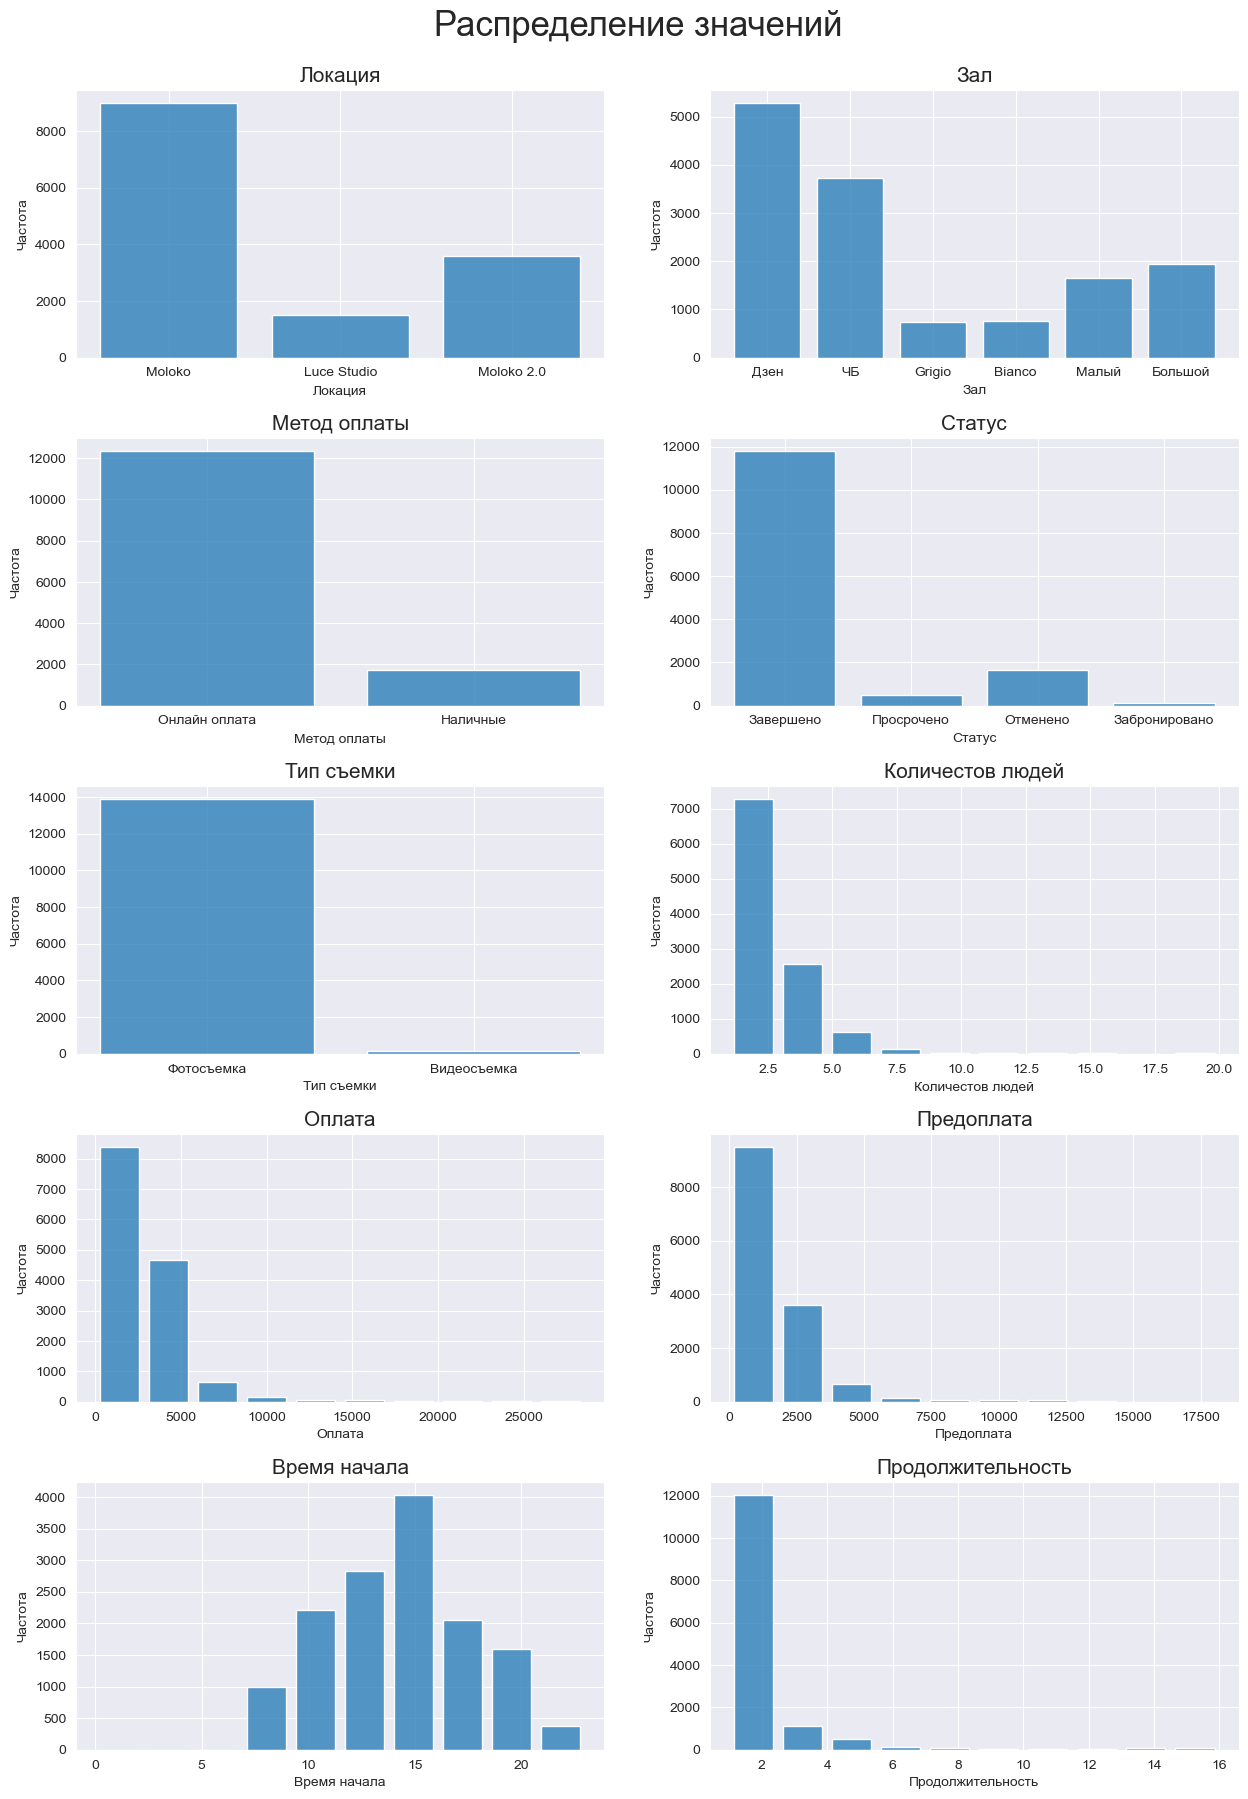

In [6]:
#Параметры для построения графиков
list_param = [
    'location', 'hall', 'payment_method', 'status', 'purpose',
    'people_count', 'amount', 'prepaid', 'start_time', 'duration'
]

#Наименования параметров для построения графиков
list_name_param = [
    'Локация', 'Зал', 'Метод оплаты', 'Статус', 'Тип съемки',
    'Количестов людей', 'Оплата', 'Предоплата', 'Время начала', 'Продолжительность'
]
#Заголовок листа
suptitle = 'Распределение значений'

#Построение графиков
hist_graph (df_main,list_param,list_name_param , suptitle)